In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [12]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data


In [13]:
#Read and plot data

DIR_FILENAME = 'dowj_1996-2018.csv'
#dataset = np.genfromtxt(DIR_FILENAME, delimiter=',')


dataset = generate_normal_time_series(8, 50, 200)

In [14]:
#Define functions

def const_hazard(r,lambda_):
    probs = np.ones(r)/lambda_
    return probs

def pred_prob(x,mu,alpha,kappa,beta):
    center = mu
    precision = (alpha*kappa)/(beta*(kappa+1))
    deg_freedom = 2*alpha
    pred = t.pdf(x, df= deg_freedom, loc= center,scale= np.sqrt(precision))
    return pred

def update_stats(x,mu,alpha,kappa,beta):
    mu, alpha, kappa, beta = (kappa*mu + x) / (kappa+1.), alpha+0.5, kappa+1., beta +(kappa*(x-mu)**2)/(2*(kappa+1.))
    return mu, alpha, kappa, beta


In [15]:
def inference(data, mu0 = 0, kappa0 = 1, alpha0= 0.1, beta0= 0.01, lam = [200]):
    #Initialize
    prob_r = np.zeros((len(data) + 1, len(data) + 1))
    prob_r[0, 0] = 1
    mu, kappa, alpha, beta = np.array([mu0]), np.array([kappa0]), np.array([alpha0]), np.array([beta0])
    
    #Start iteration   
    for t,x in enumerate(data):      
        #Calculate predictive probability for new data point
        pred = pred_prob(x,mu,alpha,kappa,beta)
        
        #Calculate growth probability 
        prob_r[1:t+2,t+1] = prob_r[:t+1,t]* pred * (1-const_hazard(t+1,lam))

        #Calculate changepoint probability
        prob_r[0,t+1] = np.sum( prob_r[:t+1,t] * pred * const_hazard(t+1,lam))
        
        #Calculate evidence
        sum_prob_r =  np.sum(prob_r[:,t+1])
        
        #Run length distribution
        prob_r[:,t+1] /= sum_prob_r
        
        #Update sufficient statistics
        mu_n, alpha_n, kappa_n, beta_n = update_stats(x, mu, alpha, kappa, beta) 
        mu, kappa, alpha, beta = np.append(np.array([mu0]), mu_n), np.append(np.array([kappa0]), kappa_n), np.append(np.array([alpha0]), alpha_n), np.append(np.array([beta0]), beta_n) 
    
        
    return prob_r

In [16]:
p = inference(dataset)

/home/esraz/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:3845: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/esraz/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:3845: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


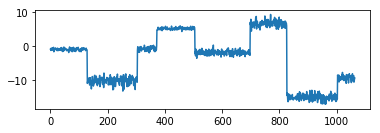

In [17]:
# plot
figure = plt.figure()
ax = figure.add_subplot(2,1,1)
ax.plot(dataset)

plt.show()

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


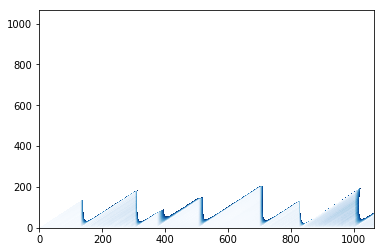

In [18]:
plt.figure()
plt.imshow(-np.log(p), interpolation='none', aspect='auto',
origin='lower', cmap=plt.cm.Blues)
plt.show()